# DU-BQP法 (２値制約付きQP問題)

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux
using Convex, SCS

### 準備 (グローバル定数の設定)

In [2]:
n = 100
m = 100
num_itr = 30
K = 500
adam_lr = 5e-4
max_inner = 40
noise_std = 3.0

A = randn(m,n)
eig = eigvals(A'*A)
λmin = minimum(eig)
λmax = maximum(eig)
ηopt = 1/λmax

0.002639093489038349

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
    x = 1.0*ones(n,K) - 2.0*rand(0:1, n,K)
    y = A*x + noise_std*randn(m, K)
    return y, x
end

mini_batch (generic function with 1 method)

### 射影関数

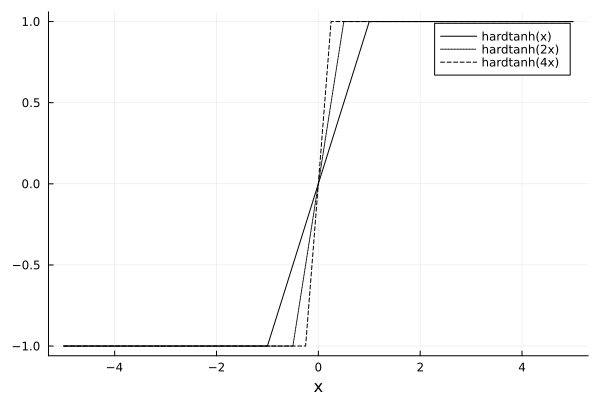

In [4]:
plot(x->hardtanh(x), label="hardtanh(x)", xlabel="x", color=:black)
plot!(x->hardtanh(2*x), label="hardtanh(2x)", color=:black, ls=:dot)
plot!(x->hardtanh(4*x), label="hardtanh(4x)", color=:black, ls=:dash)

In [5]:
savefig("proj_func.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_4/proj_func.pdf"

### 固定ステップサイズの射影勾配法法

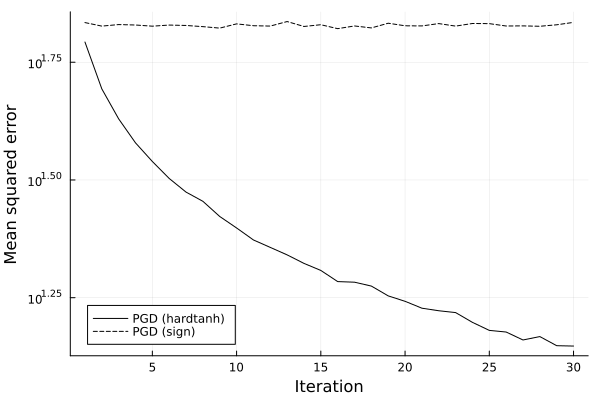

In [6]:
function ProjectedGD(max_itr, y, func)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - ηopt*A'*(A*x - y)
        x = func.(x)
    end
    return x
end

function comp_mse(max_itr, func)
    y, x_org = mini_batch(K)
    x̂ = ProjectedGD(max_itr, y, func)
    return norm(x_org - x̂)^2/K
end
        
GD_mse1 = [comp_mse(i, hardtanh) for i in 1:num_itr]
plot(1:num_itr, GD_mse1, lw=1, yscale=:log10, label="PGD (hardtanh)", color=:black,  xlabel="Iteration", ylabel="Mean squared error", legend=:bottomleft)
GD_mse2 = [comp_mse(i, sign) for i in 1:num_itr]
plot!(1:num_itr, GD_mse2, lw=1, yscale=:log10, label="PGD (sign)", ls=:dash, color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-GD反復の定義 

In [7]:
function DU_ProjectedGD(max_itr, y, η, α)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - η[i]*A'*(A*x - y)
        x = hardtanh.(α[i]*x)
    end
    return x
end

DU_ProjectedGD (generic function with 1 method)

### 損失関数の定義

In [8]:
function loss(x_opt, x̂)
    return norm(x_opt - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [9]:
function train(opt, η, α)
    ps = Flux.params(η, α) 
    for itr in 1:num_itr 
        for i in 1:max_inner 
            y, x_opt = mini_batch(K)
            gs = Flux.gradient(ps) do
                x_hat = DU_ProjectedGD(itr, y, η, α)
                loss(x_opt, x_hat)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        y, x_org = mini_batch(K)
        x̂ = DU_ProjectedGD(itr, y, η, α)
        println(itr, " ", loss(x_org, x̂))
    end
end

train (generic function with 1 method)

### DU-GDのMSE評価用関数

In [10]:
function comp_mse_DUGD(max_itr, η, α)
    y, x_org = mini_batch(K)
    x̂ = DU_ProjectedGD(max_itr, y, η, α)
    return loss(x_org, x̂)
end

comp_mse_DUGD (generic function with 1 method)

### 学習過程

1 48.22401021382376
2 35.23620660953261
3 27.39468546366975
4 19.317413020923315
5 14.451969225836594
6 11.125194943663828
7 9.798350030441474
8 8.239877085889885
9 6.808328643709959
10 5.535390666847061
11 4.600411834250026
12 3.7403120404687407
13 2.9131413794670693
14 2.606908005696914
15 2.1493818579198773
16 2.0340277928712367
17 1.8892424662143068
18 1.2779518768540556
19 1.1047069446422442
20 0.875481649519749
21 1.0042349737335639
22 0.934898019367773
23 0.7644445267211807
24 0.6970374646249285
25 0.5544410549172852
26 0.4842663624598757
27 0.6286262446159208
28 0.9120985614482644
29 0.6689579747548948
30 0.5065441100638498


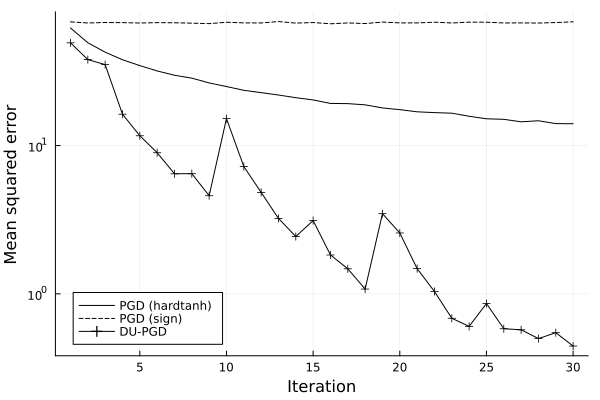

In [11]:
η_train = zeros(num_itr)
α_train = ones(num_itr)
opt = Flux.ADAM(adam_lr)
train(opt, η_train, α_train)
DUGD_mse =[comp_mse_DUGD(i, η_train, α_train) for i in 1:num_itr]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-PGD", color=:black, marker=:+)

In [12]:
savefig("DU-BQP.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_4/DU-BQP.pdf"

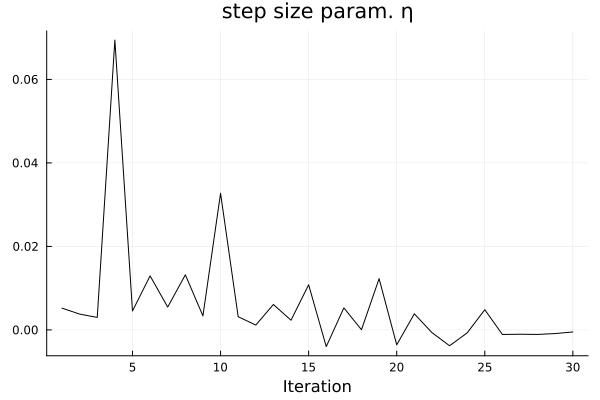

In [13]:
p1 = plot(1:num_itr, η_train, color=:black, legend=false, xlabel="Iteration", title="step size param. η")

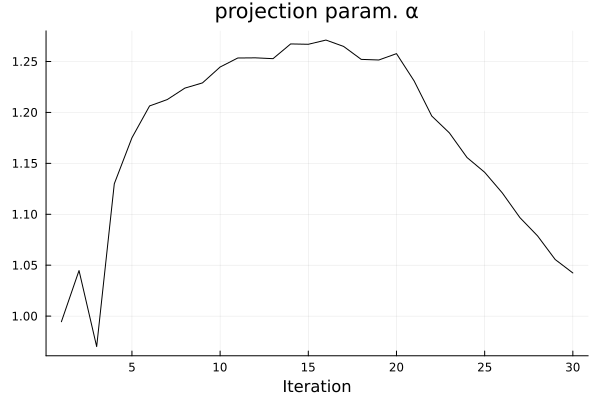

In [14]:
p2 = plot(1:num_itr, α_train, color=:black, legend=false, xlabel="Iteration", title="projection param. α")

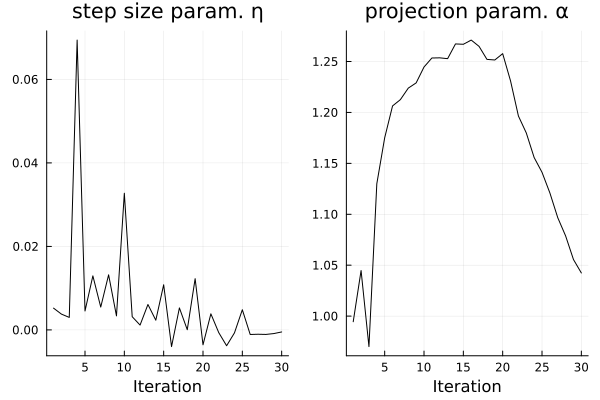

In [15]:
plot(p1,p2)

In [16]:
savefig("DU-BQP-param.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_4/DU-BQP-param.pdf"